# Experiment Notebook: Model Validation

## Table of Contents
* [Research Question](#Research-Question)
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: Profit Yields Across Validator Environments](#Analysis-1:-Profit-Yields-Across-Validator-Environments)
* [Analysis 2: Network Yields and Network Inflation](#Analysis-2:-Network-Yields-and-Network-Inflation)
* [Analysis 3: Revenue/Profit Yield Spread ("Three Region Analysis")](#Analysis-3:-Revenue/Profit-Yield-Spread-("Three-Region-Analysis"))

---

# Research Question

How accurately does that CADLabs model perform compared to a) other, well-established validator economics models and b) past on-chain data?

# Experiment Summary 

The purpose of this notebook is to recreate selected scenario analysis from the (widely acknowledged) [Hoban orgers Ethereum 2.0 Economic Model](https://docs.google.com/spreadsheets/d/1y18MoYSBLlHZ-ueN9m0a-JpC6tYjqDtpISJ6_WdicdE) using the CADLabs model, and to compare the results. 

**Analysis 1, "Profit Yields Across Validator Environments"**, plots the average profitability of validators across different validator environments in two different adoption (i.e. total ETH staked) scenarios and a wide range of ETH prices. A description of the different validator environments and respective assumptions can be found <here> (TODO: add link to description). 

**Analysis 2, "Network Yields and Network Inflation"**, combines the simulation of average (i.e. not validator environment-specific) Revenue Yields, Profit Yields (across two illutrative ETH price levels), with the associated overall network inflation. 

**Analysis 3, "Revenue/Profit Yield Spread "Three Region Analysis""**, compares the spread between average (i.e. not validator environment specific) Revenu yields and Profit yields across a wide range of ETH prices, and across the two adoption scenarios seen earlier in this notebook.

These analyses and illustrative insights will be described in further detail in their corresponding sections.

# Experiment Assumptions

Our model adopts a range of assumptions from the Hoban/Borgers Ethereum 2.0 Economic Model (notably all validator cost assumptions across validator environments).
Since the Hoban/Borgers Model was published pre-Altair and the CADLabs model post-Altair, however, some assumptions differ slightly (notably reward/penalty parameters incl. new sync committee). Hence rather than a perfect match of simulation results we expect a very close match, which will serve the purpose of a sanity check.

See [assumptions document](ASSUMPTIONS.md) for further details.

# Experiment Setup

In [1]:
import copy
import logging
import numpy as np
from radcad import Engine

import setup
import experiments.notebooks.visualizations as visualizations
from experiments.default_experiment import experiment, TIMESTEPS, DELTA_TIME
from experiments.run import run
from model.types import Stage

time: 1.85 s (started: 2021-06-17 14:48:53 +02:00)


In [2]:
logger = logging.getLogger()
logger.disabled = True

time: 29.1 ms (started: 2021-06-17 14:48:55 +02:00)


In [3]:
# From Hoban/Borgers Economic Report
state_variable_overrides = {
    "eth_supply": 112_000_000,
    "eth_price": 25,
    "eth_staked": 524_288,
    "number_of_validators": 16_384,
}

# From Hoban/Borgers Economic Report
parameter_overrides = {
    "stage": [Stage.BEACON_CHAIN],
    "daily_pow_issuance": [0],
    # Combination of validator internet, power, and technical uptime from Hoban/Borgers Report
    "validator_uptime_process": [lambda _run, _timestep: 0.999 * 0.999 * 0.982],
}

time: 29.7 ms (started: 2021-06-17 14:48:55 +02:00)


In [4]:
simulation = copy.deepcopy(experiment.simulations[0])

# Drop substeps to improve performance
simulation.engine = Engine(drop_substeps=True)
# Override base experiment System Parameters
simulation.model.params.update(parameter_overrides)
# Override base experiment State Variables
simulation.model.initial_state.update(state_variable_overrides)
# Set runs to number of ETH price / staked samples
simulation.runs = 50
# Run single timestep, set unit of time to multiple epochs
simulation.timesteps = 1
simulation.model.params.update({"dt": [TIMESTEPS * DELTA_TIME]})

time: 31 ms (started: 2021-06-17 14:48:55 +02:00)


## Analysis 1: Profit Yields Across Validator Environments

The below analysis from the Hoban/Borgers [Ethereum 2.0 Economic Model](https://docs.google.com/spreadsheets/d/1y18MoYSBLlHZ-ueN9m0a-JpC6tYjqDtpISJ6_WdicdE/edit#gid=1146360926) simulate how the average annual validator profitability varies across validator environment (deployment type) and ETH price ranges. The first analysis simulates the original beacon chain minimum requirement of 524288 ETH staked, the second analysis a much higher adoption level at 33,6m ETH staked. Insights include: (TODO: double-check insights)
* The average annual validator profitability across all validator environments is much lower in the high-adoption scenario due to systematically lower revenue yields
* As Eth approaches very slow prices levels, a "profitability cliff" exists for all non-StaaS (Staking-as-a-Service) validator deployments in both adoption scenarios (assumes that StaaS providers offer constant ETH returns)
* Average annual validator profitability between validator environments converge as adoption and ETH price grow, due to to decreasing relevance of operational costs

In a next step, we will recreate the below analysis using the CADLabs model and compare the results.

Annualized Model - Yields of Validator Environments at 524_288 ETH Staked | Annualized Model - Yields of Validator Environments at 33_600_000 ETH Staked
- | - |
![alt](../outputs/hoban_borgers_economic_model/experiment_model_validation_scenario_1a.png) | ![alt](../outputs/hoban_borgers_economic_model/experiment_model_validation_scenario_1b.png) |

### Configuration

In [5]:
# Create a copy of the simulation (TODO: describe better what's going on here)
simulation_1 = copy.deepcopy(simulation)

# From Hoban/Borgers Economic Report (TODO: describe better what's going on here)
eth_price_samples = np.linspace(start=25, stop=1500, num=50)

parameter_overrides = {
    "eth_price_process": [
        lambda run, timestep: eth_price_samples[run - 1]
    ],
    "eth_staked_process": [
        lambda _run, _timestep: 524_288,  # From Hoban/Borgers Economic Report
        lambda _run, _timestep: 33_600_000,  # From Hoban/Borgers Economic Report
    ],
}

# Override base experiment parameters
simulation_1.model.params.update(parameter_overrides)

time: 33.4 ms (started: 2021-06-17 14:48:55 +02:00)


### Execution

In [6]:
df_1, exceptions = run(simulation_1)

time: 593 ms (started: 2021-06-17 14:48:55 +02:00)


### Output Preparation

In [7]:
df_1

,stage,timestamp,eth_price,eth_supply,eth_staked,supply_inflation,network_issuance,pow_issuance,number_of_validators_in_activation_queue,average_effective_balance,...,total_online_validator_rewards_eth,total_tips_to_validators_eth,source_reward_eth,target_reward_eth,head_reward_eth,block_proposer_reward_eth,sync_reward_eth,whistleblower_rewards_eth,validating_penalties_eth,amount_slashed_eth
1,2.0,2021-06-17 14:48:54.923321,25.000000,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5
3,2.0,2021-06-17 14:48:54.923321,25.000000,1.128986e+08,33600000,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.0625,16591.302252,40.5
5,2.0,2021-06-17 14:48:54.923321,55.102041,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5
7,2.0,2021-06-17 14:48:54.923321,55.102041,1.128986e+08,33600000,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.0625,16591.302252,40.5
9,2.0,2021-06-17 14:48:54.923321,85.204082,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2.0,2021-06-17 14:48:54.923321,1439.795918,1.128986e+08,33600000,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.0625,16591.302252,40.5
193,2.0,2021-06-17 14:48:54.923321,1469.897959,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5
195,2.0,2021-06-17 14:48:54.923321,1469.897959,1.128986e+08,33600000,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.0625,16591.302252,40.5
197,2.0,2021-06-17 14:48:54.923321,1500.000000,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5


time: 75.3 ms (started: 2021-06-17 14:48:56 +02:00)


### Analysis Results

The below plots recreate Hoban/Borger's analysis using the same validator adoption levels (52488 ETH, 3360000 ETH) and cost assumptions. The profit yields across validator environments and adoption levels match very closely (e.g. at the 524288 adoption level and assuming an ETH price of 500 USD/ETH, profit yields for a StaaS validator are shown at around 18%; those were profitable days), e.g. We conclude that the model is valid for this specific analysis.

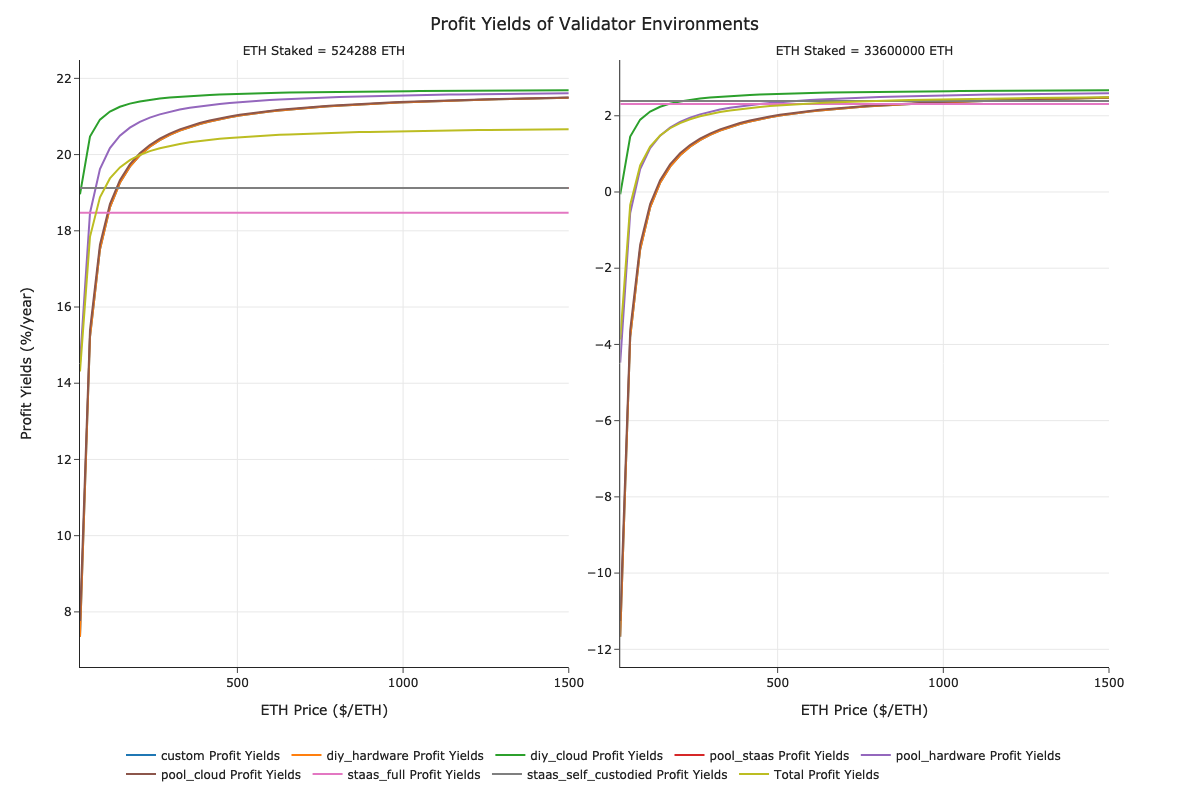

time: 245 ms (started: 2021-06-17 15:27:43 +02:00)


In [49]:
visualizations.plot_validator_environment_yields(df_1.copy())

## Analysis 2: Network Yields and Network Inflation

The below analysis from the Hoban/Borgers [Ethereum 2.0 Economic Model](https://docs.google.com/spreadsheets/d/1y18MoYSBLlHZ-ueN9m0a-JpC6tYjqDtpISJ6_WdicdE/edit#gid=1146360926) combines the simulation of average (i.e. not validator environment-specific) Revenue Yields, Profit Yields (across two illutrative ETH price levels), with the associated overall network inflation. Illustrative insights include: (TODO: double-check insights in Economic Report)

* Both Revenue Yields and Profit Yields decrease systematically as adoption grows (base reward decreases at square root of number of validators, hence yields decrease)
* Profit Yields at the 25 USD/ETH price level are lower (in fact negative as adoption grows) than at the 1500 USD/ETH ETH price level (decreasing relevance of operational costs)
* Network issuance is expected to stay below 1,00% per year (and in fact turn negative after EIP1559 implementation) 

In a next step, we will recreate the below analysis using the CADLabs model and compare the results.

In [10]:
net_yield_at_1500_dollars = 20.48
net_yield_at_25_dollars = 14.39

time: 25.1 ms (started: 2021-06-17 14:48:57 +02:00)


In [11]:
# Difference between net yields for each ETH price scenario
net_yield_at_1500_dollars - net_yield_at_25_dollars

6.09

time: 26.1 ms (started: 2021-06-17 14:48:57 +02:00)


Annualized Model - Rev Yields vs. Network Inflation
<span style="display:block;"><img src="../outputs/hoban_borgers_economic_model/experiment_model_validation_scenario_2.png" width="50%"/></span>

### Configuration

In [12]:
# Create a copy of the simulation
simulation_2 = copy.deepcopy(simulation)

eth_staked_samples = np.linspace(
    524_288,  # From Hoban/Borgers Economic Report
    33_600_000,  # From Hoban/Borgers Economic Report
    50
)

parameter_overrides = {
    "eth_staked_process": [
        lambda run, timestep: eth_staked_samples[run - 1],
    ],
    "eth_price_process": [
        # A sweep of two fixed ETH price points
        lambda _run, _timestep: 25,  # From Hoban/Borgers Economic Report
        lambda _run, _timestep: 1500,  # From Hoban/Borgers Economic Report
    ],
}

# Override base experiment parameters
simulation_2.model.params.update(parameter_overrides)

time: 32.2 ms (started: 2021-06-17 14:48:57 +02:00)


### Execution

In [13]:
df_2, exceptions = run(simulation_2)

time: 627 ms (started: 2021-06-17 14:48:57 +02:00)


### Output Preparation

In [14]:
df_2

,stage,timestamp,eth_price,eth_supply,eth_staked,supply_inflation,network_issuance,pow_issuance,number_of_validators_in_activation_queue,average_effective_balance,...,total_online_validator_rewards_eth,total_tips_to_validators_eth,source_reward_eth,target_reward_eth,head_reward_eth,block_proposer_reward_eth,sync_reward_eth,whistleblower_rewards_eth,validating_penalties_eth,amount_slashed_eth
1,2.0,2021-06-17 14:48:54.923321,25,1.121123e+08,5.242880e+05,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.062500,2072.872620,40.500000
3,2.0,2021-06-17 14:48:54.923321,1500,1.121123e+08,5.242880e+05,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.062500,2072.872620,40.500000
5,2.0,2021-06-17 14:48:54.923321,25,1.121698e+08,1.199303e+06,0.001538,169804.022002,0.0,0,3.200000e+10,...,169844.522002,0.0,37718.158016,70048.007743,37718.158016,21992.160960,5498.040240,5.062500,3135.065472,40.500000
7,2.0,2021-06-17 14:48:54.923321,1500,1.121698e+08,1.199303e+06,0.001538,169804.022002,0.0,0,3.200000e+10,...,169844.522002,0.0,37718.158016,70048.007743,37718.158016,21992.160960,5498.040240,5.062500,3135.065472,40.500000
9,2.0,2021-06-17 14:48:54.923321,25,1.122123e+08,1.874317e+06,0.001923,212252.224791,0.0,0,3.200000e+10,...,212292.724791,0.0,47145.106321,87555.197454,47145.106321,27488.689416,6872.172354,5.062500,3918.609576,40.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2.0,2021-06-17 14:48:54.923321,1500,1.128798e+08,3.224997e+07,0.007969,879764.625024,0.0,0,3.199999e+10,...,879805.125006,0.0,195387.818194,362863.090932,195387.818194,113924.461392,28481.115348,5.062498,16244.241552,40.499982
193,2.0,2021-06-17 14:48:54.923321,25,1.128881e+08,3.292499e+07,0.008045,888087.218524,0.0,0,3.199999e+10,...,888127.718515,0.0,197236.101610,366295.617276,197236.101610,115002.125568,28750.531392,5.062499,16397.821440,40.499991
195,2.0,2021-06-17 14:48:54.923321,1500,1.128881e+08,3.292499e+07,0.008045,888087.218524,0.0,0,3.199999e+10,...,888127.718515,0.0,197236.101610,366295.617276,197236.101610,115002.125568,28750.531392,5.062499,16397.821440,40.499991
197,2.0,2021-06-17 14:48:54.923321,25,1.128986e+08,3.360000e+07,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.062500,16591.302252,40.500000


time: 69.1 ms (started: 2021-06-17 14:48:57 +02:00)


### Analysis Results

The below plot recreate Hoban/Borger's analysis. The Profit Yields in either ETH price scenario differ slightly between the Hoban/Borgers and the CADLabs model - likely due to the Altair updates - whereas the annualized inflation rates match very closely, within `0.01` of a percent. We conclude that the model is valid for this specific scenario analysis.

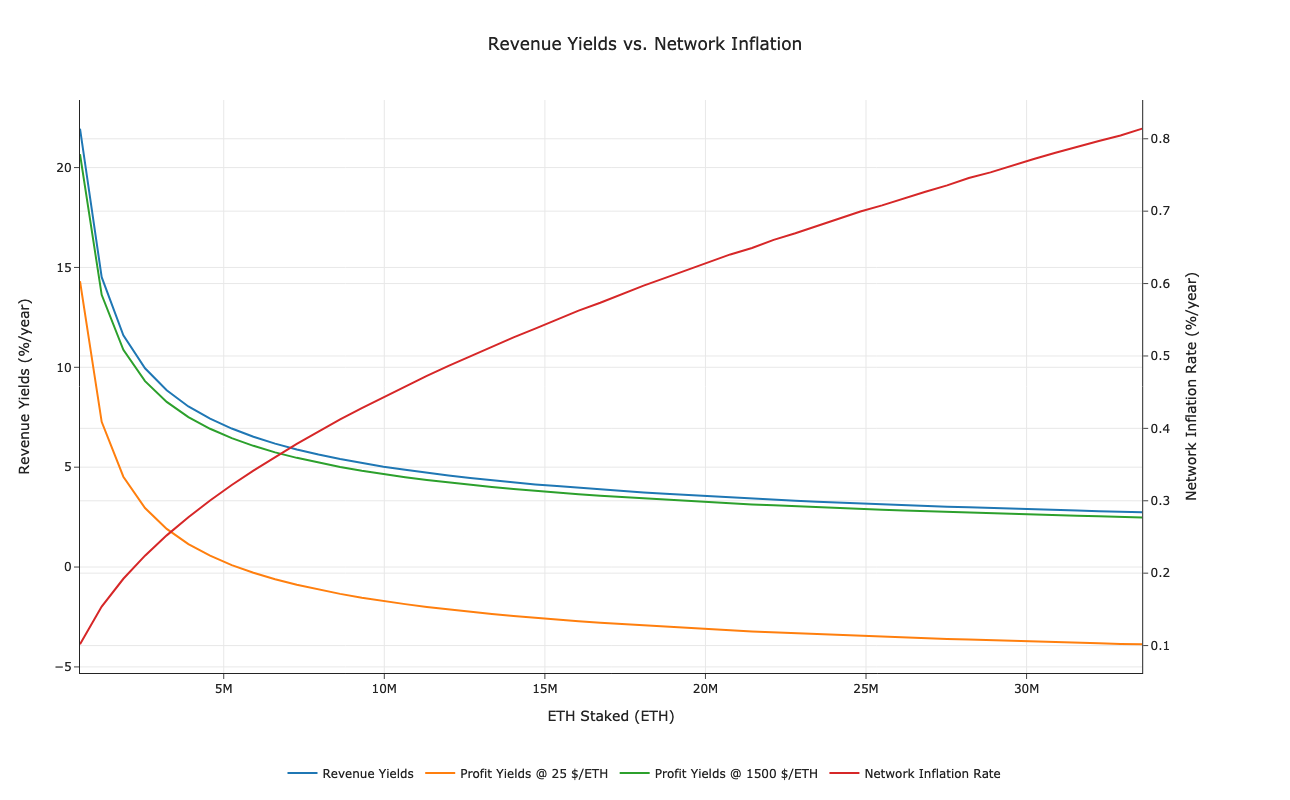

time: 109 ms (started: 2021-06-17 14:48:58 +02:00)


In [15]:
visualizations.plot_revenue_yields_vs_network_inflation(df_2)

In [16]:
# Difference between net yields for each ETH price scenario
df_2.query('subset == 1').iloc[0]['total_profit_yields_pct'] - df_2.query('subset == 0').iloc[0]['total_profit_yields_pct']

6.356742845833331

time: 41 ms (started: 2021-06-17 14:48:58 +02:00)


In [17]:
# Minimum and maximum annualized inflation rate
(df_2.query('subset == 0')['supply_inflation'] * 100).describe()

count    50.000000
mean      0.547942
std       0.191176
min       0.101692
25%       0.416339
50%       0.579629
75%       0.705918
max       0.813983
Name: supply_inflation, dtype: float64

time: 37.6 ms (started: 2021-06-17 14:48:58 +02:00)


## Analysis 3: Revenue/Profit Yield Spread ("Three Region Analysis")

The below "Thee Region Analysis" from the Hoban/Borgers [Ethereum 2.0 Economic Model](https://docs.google.com/spreadsheets/d/1y18MoYSBLlHZ-ueN9m0a-JpC6tYjqDtpISJ6_WdicdE/edit#gid=1146360926) compare the spread between average (i.e. not validator environment specific) Revenu yields and Profit yields across a wide range of ETH prices, and across the two adoption scenarios seen earlier in this notebook. Illustrative insights include:

* As Eth approaches very slow prices levels, a "profitability cliff" exists either of the two adoption scenarios, as operational costs squeeze validators' margins
* The Revenue/Profit Yield Spread is smaller in the high-adoption-scenario, as (TODO: ADD RATIONALE FOR TIGTHER SPREAD)

In a next step, we will recreate the below analysis using the CADLabs model and compare the results.

Annualized Model - Revenue Net Yield Spread at 524_288 ETH Staked | Annualized Model - Revenue Net Yield Spread at 33_600_000 ETH Staked
- | - |
![alt](../outputs/hoban_borgers_economic_model/experiment_model_validation_scenario_3a.png) | ![alt](../outputs/hoban_borgers_economic_model/experiment_model_validation_scenario_3b.png) |

### Configuration

In [18]:
# Create a copy of the simulation
simulation_3 = copy.deepcopy(simulation)


# ETH price range from Hoban/Borgers Economic Report
eth_price_samples = np.linspace(start=25, stop=1500, num=50)

parameter_overrides = {
    "eth_price_process": [
        lambda run, _timestep: eth_price_samples[run - 1]
    ],
    "eth_staked_process": [
        # A sweep of two fixed ETH staked points
        lambda _run, _timestep: 524_288,  # From Hoban/Borgers Economic Report
        lambda _run, _timestep: 33_600_000,  # From Hoban/Borgers Economic Report
    ],
}

# Override base experiment parameters
simulation_3.model.params.update(parameter_overrides)

time: 33.4 ms (started: 2021-06-17 14:48:58 +02:00)


### Execution

In [19]:
df_3, exceptions = run(simulation_3)

time: 554 ms (started: 2021-06-17 14:48:58 +02:00)


### Output Preparation

In [20]:
df_3

,stage,timestamp,eth_price,eth_supply,eth_staked,supply_inflation,network_issuance,pow_issuance,number_of_validators_in_activation_queue,average_effective_balance,...,total_online_validator_rewards_eth,total_tips_to_validators_eth,source_reward_eth,target_reward_eth,head_reward_eth,block_proposer_reward_eth,sync_reward_eth,whistleblower_rewards_eth,validating_penalties_eth,amount_slashed_eth
1,2.0,2021-06-17 14:48:54.923321,25.000000,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5
3,2.0,2021-06-17 14:48:54.923321,25.000000,1.128986e+08,33600000,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.0625,16591.302252,40.5
5,2.0,2021-06-17 14:48:54.923321,55.102041,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5
7,2.0,2021-06-17 14:48:54.923321,55.102041,1.128986e+08,33600000,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.0625,16591.302252,40.5
9,2.0,2021-06-17 14:48:54.923321,85.204082,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2.0,2021-06-17 14:48:54.923321,1439.795918,1.128986e+08,33600000,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.0625,16591.302252,40.5
193,2.0,2021-06-17 14:48:54.923321,1469.897959,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5
195,2.0,2021-06-17 14:48:54.923321,1469.897959,1.128986e+08,33600000,0.008140,898570.797092,0.0,0,3.200000e+10,...,898611.297092,0.0,199564.301323,370619.416743,199564.301323,116359.613964,29089.903491,5.0625,16591.302252,40.5
197,2.0,2021-06-17 14:48:54.923321,1500.000000,1.121123e+08,524288,0.001017,112259.926774,0.0,0,3.200000e+10,...,112300.426774,0.0,24938.696305,46314.721709,24938.696305,14540.898060,3635.224515,5.0625,2072.872620,40.5


time: 62.7 ms (started: 2021-06-17 14:48:58 +02:00)


### Analysis Results

The below plots recreate Hoban/Borger's analysis. The revenue net yield spread for our model closely matches the Hoban/Borgers Ethereum 2.0 Economic Model for both scenarios. We can conclude that the model is valid for this specific scenario analysis.

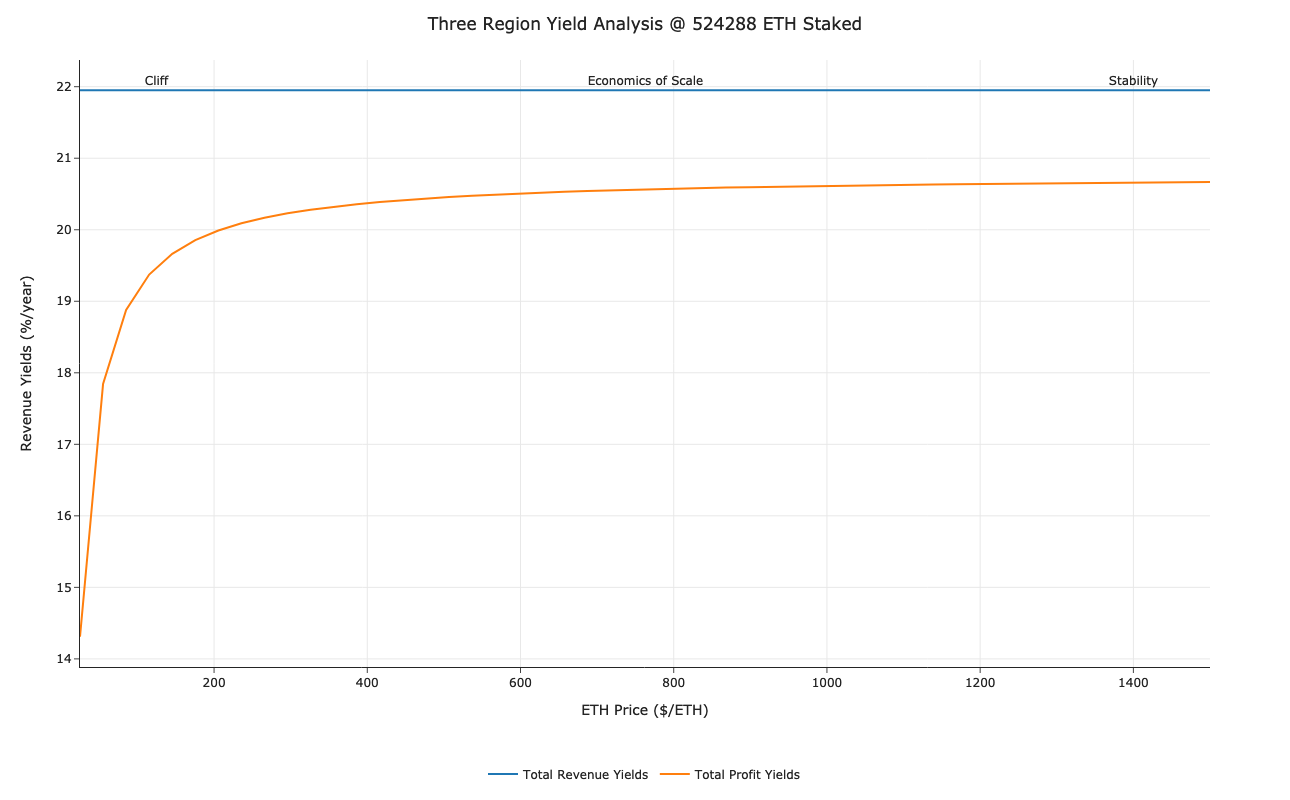

time: 157 ms (started: 2021-06-17 14:48:58 +02:00)


In [21]:
visualizations.plot_three_region_yield_analysis(df_3.query('subset == 0').copy())

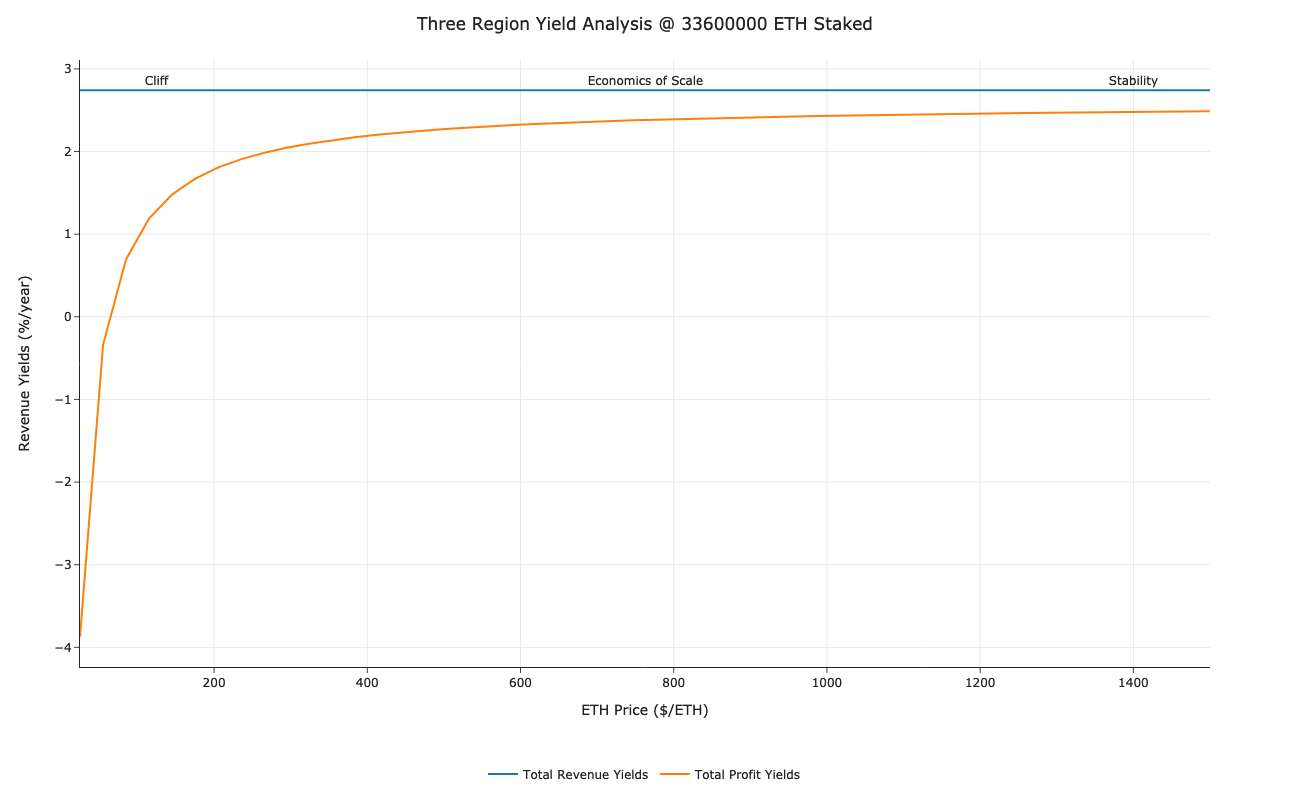

time: 203 ms (started: 2021-06-17 14:48:59 +02:00)


In [22]:
visualizations.plot_three_region_yield_analysis(df_3.query('subset == 1').copy())